Traducido al español de http://www.astropy.org/astropy-tutorials/Coordinates.html hecha por Germán Chaparro, junto con material adicional.

# Tutorial de Astropy en español

## Usando `astropy.coordinates` 

En esta parte del tutorial, exploraremos cómo el paquete `astropy.coordinates` junto con la funcionalidad general de astropy puede ser usado para planear observaciones y en general obtener información que requiera el uso de catálogos astronómicos grandes.

In [1]:
import urllib
import IPython.display
import numpy as np

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import astropy as ap
from astropy import units as u
from astropy.coordinates import SkyCoord

## Determinando lugares en el cielo con `coordinates`

Comencemos considerando un campo alrededor del pintoresco Grupo Compacto Hickson 7 (HCG7). Primero necesitamos obtener un objeto que represente las coordenadas del centro de este grupo.

En Astropy, el objeto más común para trabajar coordenadas es `SkyCoord`.  Un `SkyCoord` puede ser creado simplemente a partir de ángulos como se muestra más abajo. Es recomendable especificar el marco de referencia de sus coordenadas, aunque no es estrictamente necesario, ya que por defecto se usa el estándar ICRS de la IAU. Este estándar se puede entender como aproximadamente igual al sistema ecuatorial en el equinoxio de J2000, y se da en RA/DEC.

https://en.wikipedia.org/wiki/International_Celestial_Reference_System

In [9]:
SkyCoord?

Init signature: SkyCoord(*args, copy=True, **kwargs)
Docstring:     
High-level object providing a flexible interface for celestial coordinate
representation, manipulation, and transformation between systems.

The `SkyCoord` class accepts a wide variety of inputs for initialization. At
a minimum these must provide one or more celestial coordinate values with
unambiguous units.  Inputs may be scalars or lists/tuples/arrays, yielding
scalar or array coordinates (can be checked via ``SkyCoord.isscalar``).
Typically one also specifies the coordinate frame, though this is not
required. The general pattern for spherical representations is::

  SkyCoord(COORD, [FRAME], keyword_args ...)
  SkyCoord(LON, LAT, [FRAME], keyword_args ...)
  SkyCoord(LON, LAT, [DISTANCE], frame=FRAME, unit=UNIT, keyword_args ...)
  SkyCoord([FRAME], <lon_attr>=LON, <lat_attr>=LAT, keyword_args ...)

It is also possible to input coordinate values in other representations
such as cartesian or cylindrical.  In this ca

In [5]:
hcg7_center = SkyCoord(9.81625*u.deg, 0.88806*u.deg, frame='icrs')
hcg7_center

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>

`SkyCoord` también acepta coordenadas formateadas como `strings` ya sea como  `strings` separados para RA/DEC o como un `string` simple. Si las unidades no vienen en el `string` original, usted tiene que especificarlas.

In [6]:
SkyCoord('23h39m15.9s', '0d53m17.016s', frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (354.81625, 0.88806)>

In [7]:
SkyCoord('0:39:15.9 0:53:17.016', unit=(u.hour, u.deg), frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>

Si el objeto que le interesa está en [SESAME](http://cdsweb.u-strasbg.fr/cgi-bin/Sesame), usted puede hallarlo directamente usando el método de clase<sup>1</sup> `SkyCoord.from_name()`. Esto requiere que usted esté conectado a internet. Dado que ya lo definimos explícitamente, no es necesario ejecutar este paso si usted no está conectado a internet.

<sub> <sup>1</sup>Un objeto de clase es un constructor alternativo para un objeto `SkyCoord` object. Si usted llama la  `SkyCoord.from_name()` con un nombre, va a generar un nuevo objeto `SkyCoord`. Para más información sobre los objetos de clase y su uso, vea [esta página](https://julien.danjou.info/blog/2013/guide-python-static-class-abstract-methods).</sub>

In [10]:
hcg7_center = SkyCoord.from_name('Hcg 7')
hcg7_center

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88805556)>

In [11]:
Black_Hole = SkyCoord.from_name('Sgr A*')
Black_Hole

<SkyCoord (ICRS): (ra, dec) in deg
    (266.41681662, -29.00782497)>

El objeto que acabamos de crear nos da varias formas útiles de tener acceso a la información que almacena. En particular se usan los atributos ``ra`` y ``dec``, que son objetos [``Quantity``](http://docs.astropy.org/en/stable/units/index.html) de Astropy especializados (de hecho, pertenecen a una sub-clase llamada [``Angle``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Angle.html), cuyas subclases son [``Latitude``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Latitude.html) y [``Longitude``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Longitude.html)).  Estos objetos almacenan ángulos y muestran representaciones bonitas de ellos. También tiene atributos útiles para convertir fácilmente a unidades comunes de ángulo.

In [12]:
type(hcg7_center.ra), type(hcg7_center.dec)

(astropy.coordinates.angles.Longitude, astropy.coordinates.angles.Latitude)

In [13]:
hcg7_center.dec

<Latitude 0.88805556 deg>

In [14]:
hcg7_center.ra

<Longitude 9.81625 deg>

In [15]:
hcg7_center.dec.hour

0.05920370400000001

Ahora que tenemos un objeto `SkyCoord`, podemos usarlo para acceder a datos del [Sloan Digital Sky Survey](http://www.sdss.org/) (SDSS).  Empecemos intentando obtener una imagen usando la herramienta de recorte de imágenes de SDSS para asegurarnos que HGC7 está incluido en el catálogo SDSS y que tiene buena calidad de imagen.

Esto requiere estar conectado a internet, pero si falla, el archivo ``'HCG7_SDSS_cutout.jpg'`` se incluye en el repositorio.

In [23]:
impix = 1024
imsize = 12*u.arcmin
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urllib.parse.urlencode(dict(ra=hcg7_center.ra.deg, 
                                     dec=hcg7_center.dec.deg, 
                                     width=impix, height=impix, 
                                     scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

urllib.request.urlretrieve(url, 'HCG7_SDSS_cutout.jpg')

('HCG7_SDSS_cutout.jpg', <http.client.HTTPMessage at 0x7f8e3966a2d0>)

In [24]:
urllib.parse.urlencode(dict(ra=hcg7_center.ra.deg, 
                                     dec=hcg7_center.dec.deg, 
                                     width=impix, height=impix, 
                                     scale=imsize.to(u.arcsec).value/impix))

'ra=9.81625&dec=0.88805556&width=1024&height=1024&scale=0.703125'

Ahora miremos la imagen.

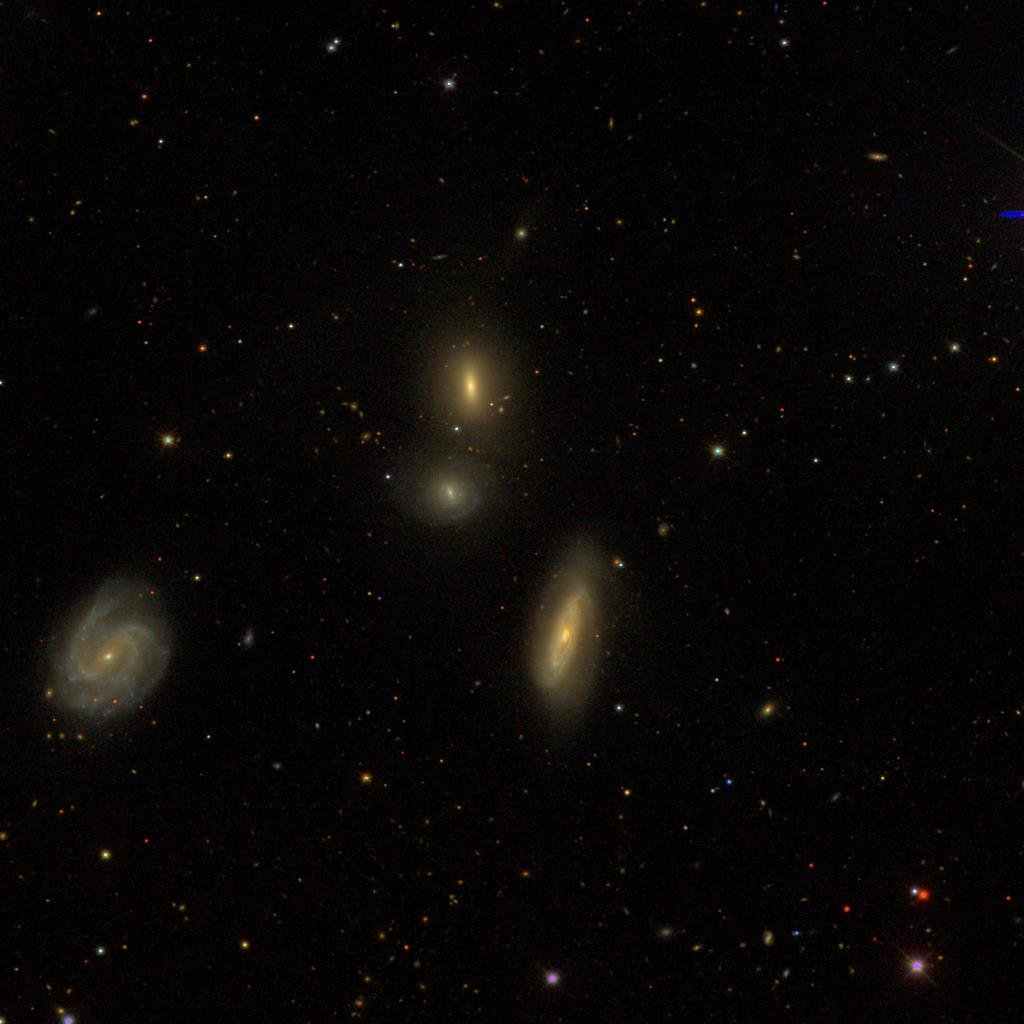

In [25]:
IPython.display.Image('HCG7_SDSS_cutout.jpg')

¡Bonito!

### Ejercicios

Cree un `SkyCoord` de algún otro objeto astronómico de su interés. Usando una sola llamada/instrucción, obtenga la RA/Dec en la forma 'HH:MM:SS.S DD:MM:SS.S'.  Revise su respuesta contra [SIMBAD](http://simbad.u-strasbg.fr/simbad/), que le mostrará las coordenadas correctas para su objeto.

(Consejo: Puede valer la pena leer la documentación de `SkyCoord.to_string()`)

In [28]:
andromeda = SkyCoord.from_name('andromeda')

<SkyCoord (ICRS): (ra, dec) in deg
    (10.68470833, 41.26875)>

Ahora obtenga una imagen de su objeto del Digitized Sky Survey y descárguela y/o muéstrela en el notebook. Puntos extra si encuentra el truco (con una sola instrucción) para mostrar la imagen en el notebook *sin* descargar el archivo.

(Consejo: STScI tiene en sus archivos una [copia del DSS](https://archive.stsci.edu/dss/).  El patrón para la URL es ``http://archive.stsci.edu/cgi-bin/dss_search?f=GIF&ra=RA&dec=DEC``)

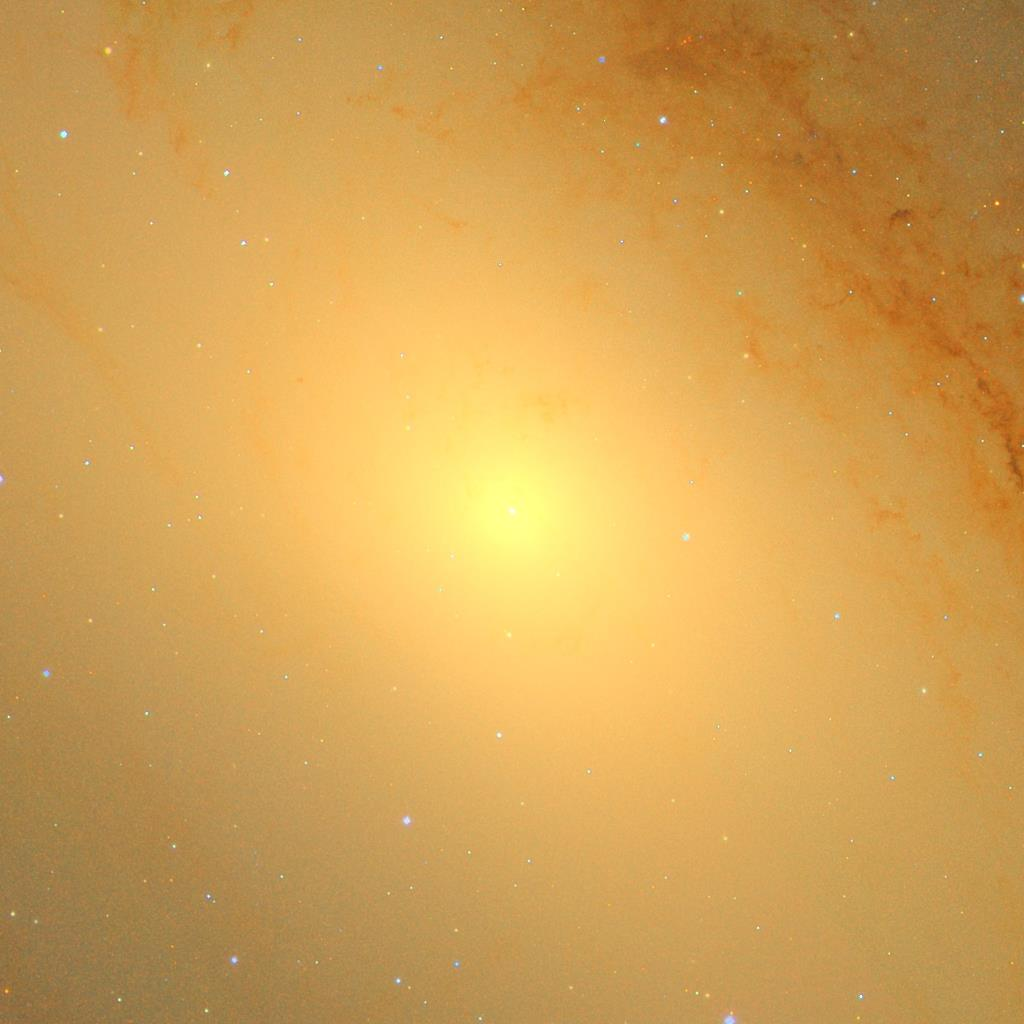

In [31]:
impix = 1024
imsize = 12*u.arcmin
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urllib.parse.urlencode(dict(ra=andromeda.ra.deg, 
                                     dec=andromeda.dec.deg, 
                                     width=impix, height=impix, 
                                     scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

urllib.request.urlretrieve(url, 'andromeda.jpg')

IPython.display.Image('andromeda.jpg')

## Transformando entre sistemas de coordenadas y planeación de observaciones

Supongamos que usted quiere estudiar alguno de los objetos en este catálogo, y usted quiere saber cuando puede observarlo. Afortunadamente `astropy.coordinates` nos da esta información.

### Introduciendo transformaciones de coordenadas

Para enteder lo que viene a continuación, recomendamos leer el [resumen del esquema de coordenadas de astropy](http://astropy.readthedocs.org/en/latest/coordinates/index.html#overview-of-astropy-coordinates-concepts).  Lo importante es saber que todas las coordenadas en astropy están en "marcos de referencia" particulares, y podemos transformar el mismo objeto `SkyCoord` de un marco a otro.  Pdemos transformar nuestro centro de HCG7 de ICRS a coordenadas galácticas:

In [32]:
hcg7_center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (116.47556718, -61.83099914)>

In [33]:
hcg7_center

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88805556)>

Lo anterior nos permite hacer una visualización rápida del cambio de coordenadas. También es posible usar el método `transform_to()` para hacer este cambio.

In [34]:
from astropy.coordinates import Galactic
hcg7_center.transform_to(Galactic())

<SkyCoord (Galactic): (l, b) in deg
    (116.47556718, -61.83099914)>

El cambio de coordenadas cambia la estructura del objeto.

In [35]:
hcg7_center.galactic.ra  # esto debe dar un mensaje de error, las coordenadas galácticas no se dan en RA/DEC

AttributeError: 'SkyCoord' object has no attribute 'ra'

In [36]:
hcg7_center.galactic.b

<Latitude -61.83099914 deg>

### Cambio a coordenadas AltAz

Para hacer observaciones, necesitamos hacer un cambio de coordenadas a un sistema basado en donde está el observador. Lo más común es usar coordenadas horizontales, o "AltAz". Necesitamos especificar desde donde queremos observar.

In [41]:
from astropy.coordinates import EarthLocation
from astropy.time import Time

observing_location = EarthLocation(lat='4d', lon='-72d', height=2600*u.m)  # Bogotá
# Si se usa astropy v1.1 o más reciente, se puede reemplazar por la ubicación del observatorio:
#observing_location = EarthLocation.of_site('Kitt Peak')

#observing_time = Time('2015-12-21 1:00')
observing_time = Time.now()
observing_time

<Time object: scale='utc' format='datetime' value=2022-01-26 15:50:59.751370>

Ahora usamos lo anterior para crear un objeto en el marco `AltAz`. Este marco tiene información sobre la atmósfera, que puede ser usado para corregir por refracción atmosférica.

In [42]:
from astropy.coordinates import AltAz

aa = AltAz(location=observing_location, obstime=observing_time)
aa

<AltAz Frame (obstime=2022-01-26 15:50:59.751370, location=(1966985.09481352, -6053757.64417669, 442126.47207974) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)>

Ahora transformamos nuestro `SkyCoord` en ICRS a `AltAz` para encontrar la ubicación en el cielo.

In [44]:
hcg7_center.transform_to(aa)

<SkyCoord (AltAz: obstime=2022-01-26 15:50:59.751370, location=(1966985.09481352, -6053757.64417669, 442126.47207974) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (89.79343789, 11.61485086)>

Ejercicio: Determine la longitud galáctica en ángulo horario a la que apunta el cenit en este momento en Medellín.

## Unidades

In [45]:
import astropy.units as u
import astropy.constants as const

In [49]:
c=const.c
c

<<class 'astropy.constants.codata2018.CODATA2018'> name='Speed of light in vacuum' value=299792458.0 uncertainty=0.0 unit='m / s' reference='CODATA 2018'>

In [66]:
freq=1420*u.MHz
freq


<Quantity 1420. MHz>

In [67]:
type(freq)

astropy.units.quantity.Quantity

In [68]:
c/freq

<Quantity 211121.44929577 m / (MHz s)>

In [69]:
(c/freq).to(u.cm)

<Quantity 21.11214493 cm>

In [70]:
(c/freq).decompose()

<Quantity 0.21112145 m>

In [75]:
print(const.G)

  Name   = Gravitational constant
  Value  = 6.6743e-11
  Uncertainty  = 1.5e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2018


In [76]:
c.cgs

<Quantity 2.99792458e+10 cm / s>

In [78]:
(1*u.au).si

<Quantity 1.49597871e+11 m>

# Archivos FITS

## Visualizando imágenes en archivos FITS

Imagen procesada del disco de escombros de Fomalhaut basada en imágenes tomadas por el Hubble Space Telescope. https://github.com/saint-germain/cazandoplanetas

In [6]:
from astropy.io import fits

In [7]:
fomalhaut=fits.open("https://github.com/saint-germain/cazandoplanetas/raw/66fb7ce82feb5e983e465b7cfd1a638d8bc3f038/Intermedio/PCA_FOMAL_full_centroids.fits")

In [11]:
fomalhaut
fomalhaut.info()

Filename: /home/jovyan/.astropy/cache/download/url/babdce75c785d3e44afc57fb60e3e07d/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1250   (2000, 2000)   float32   


In [16]:
hst_img=fomalhaut[0].data

In [21]:
hst_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
hst_img.max()

0.9672259

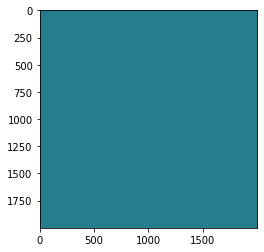

In [23]:
plt.imshow(hst_img)

(1100.0, 1400.0)

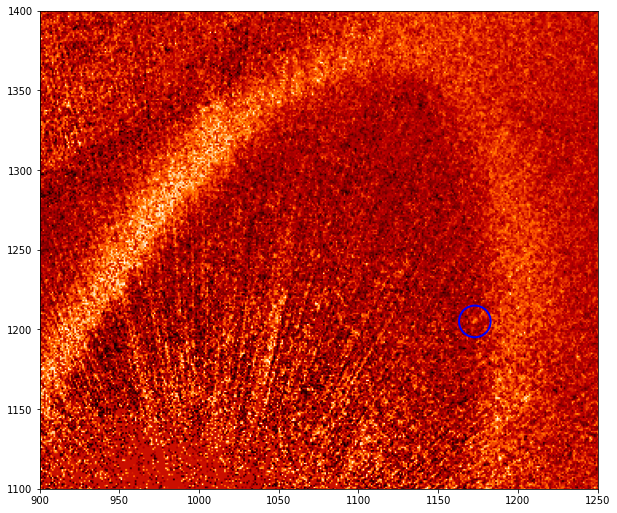

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(hst_img*(hst_img>-0.0045)*(hst_img<0.004),cmap="gist_heat")
plt.scatter(1173,1205,s=1000,facecolors='none', edgecolors='b',lw=2)
plt.xlim(900,1250)
plt.ylim(1100,1400)

### Explorando un cubo de datos en un archivo FITS

Datos de espectros de CO galáctico (CO J = 1–0 line, vrest = 115.27 GHz) tomados por el radiotelescopio MINI (Crédito: Leonardo Bronfman, U. de Chile).

In [25]:
cubo = fits.open("southgal_fixbadc.fits") #abrir objeto cubo de datos

In [27]:
cubo.info()

Filename: southgal_fixbadc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      32   (306, 385, 33)   int16 (rescales to float32)   


In [28]:
cubo[0].data

array([[[ 0.00667214,  0.00667214,  0.00667214, ...,  0.00667214,
         -0.03789592, -0.14931607],
        [ 0.00667214,  0.00667214,  0.00667214, ...,  0.00667214,
         -0.08246398,  0.00667214],
        [ 0.00667214,  0.00667214,  0.00667214, ...,  0.00667214,
         -0.12703204,  0.14037609],
        ...,
        [ 0.00667214,  0.00667214,  0.00667214, ...,  0.00667214,
          0.00667214,  0.00667214],
        [ 0.00667214,  0.00667214,  0.00667214, ...,  0.00667214,
          0.00667214,  0.00667214],
        [ 0.00667214,  0.00667214,  0.00667214, ...,  0.00667214,
          0.00667214,  0.00667214]],

       [[ 0.00667214,  0.00667214,  0.00667214, ...,  0.02895594,
         -0.08246398, -0.12703204],
        [ 0.00667214,  0.00667214,  0.00667214, ..., -0.01561189,
         -0.03789592,  0.02895594],
        [ 0.00667214,  0.00667214,  0.00667214, ..., -0.06017995,
         -0.03789592,  0.16266012],
        ...,
        [ 0.00667214,  0.00667214,  0.00667214, ...,  

In [29]:
cubo[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T  / Standard FITS format                          
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3  / Number of axes                                
NAXIS1  =                  306  / Number pixels on axis 1                       
NAXIS2  =                  385  / Number pixels on axis 2                       
NAXIS3  =                   33  / Number pixels on axis 3                       
CTYPE1  = 'VELO-LSR'            / axis 1 coord type                             
CRVAL1  =        -2.307985E+02 / coord value at CRPIX1                          
CDELT1  =         1.300400E+00 / pixel spacing for axis 1                       
CRPIX1  =             1.000000  / ref pixel for axis 1                          
CTYPE2  = 'GLON-FLT'            / axis 2 coord type                             
CRVAL2  =         3.000000E+02 / coord value at CRPIX2                          
CDELT2  =         1.250000E-

In [30]:
def values(h,j):
	N=h['NAXIS'+str(j)];
	val=np.zeros(N);
	for i in range(0,N):
		val[i] = (i+1-float(h['CRPIX'+str(j)]))*float(h['CDELT'+str(j)]) + float(h['CRVAL'+str(j)]);
	return val;

cubo	= fits.open("southgal_fixbadc.fits") #abrir objeto cubo de datos
data 	= cubo[0].data #extraer matriz de datos
header	= cubo[0].header #extraer el header del archivo fits
#print header

#Estos seran los tres arreglos con los valores reales de los tres ejes del cubo
velocidad=values(header,1)
longitud=values(header,2)
latitud=values(header,3)

In [31]:
i_l=-1
i_b=-1
T = data[i_b][i_l][:]

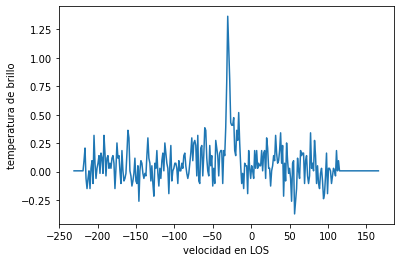

In [36]:
plt.plot(velocidad,T)
plt.xlabel('velocidad en LOS')
plt.ylabel('temperatura de brillo')

#Cada apuntamiento tiene un espectro
plt.show()

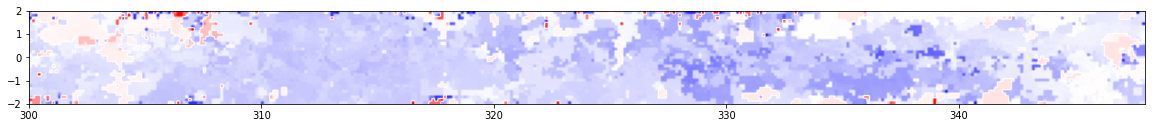

In [51]:
maxeix=np.argmax(data,axis=2)
varr=np.array([velocidad[i] for i in maxeix.ravel()]).reshape(maxeix.shape)
plt.figure(figsize=(20,5))
plt.imshow(varr,cmap='bwr',extent=[longitud[0],longitud[-1],latitud[0],latitud[-1]])

#Colorea cada pixel en función del corrimiento que se encuentra en el espectro de ese pixel.
#el color muestra si se acerca o se aleja
plt.show()

También existe una librería llamada spectral_cube que puede procesar automáticamente este tipo de cubos de datos en formato fits (estandarizados): https://learn.astropy.org/tutorials/FITS-cubes.html

## Tablas (Votable) y WCS

Exploración de datos xml en formato Votable: el caso de las estrellas en el grupo móvil Lower Centaurus Crux (LCC).

Ir a SIMBAD, buscar "lcc", children objects, descargar Votable

Enlace:
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NAME%20LCC&NbIdent=query_hlinks&Coord=12%2019-57.1&parents=1&children=1938&submit=children&siblings=19&hlinksdisplay=h_all

In [52]:
from astropy.io.votable import parse_single_table
votable = parse_single_table("lcc_simbad_votable.xml").to_table()

In [53]:
votable

TYPED_ID,ANG_DIST,MAIN_ID,OTYPE_S,RA_d,DEC_d,COO_ERR_MAJA_d,COO_ERR_MINA_d,COO_ERR_ANGLE_d,PMRA,PMDEC,PM_ERR_MAJA,PM_ERR_MINA,PM_ERR_ANGLE,PLX_VALUE,RV_VALUE,Z_VALUE,GALDIM_MAJAXIS,GALDIM_MINAXIS,GALDIM_ANGLE,SP_TYPE,MORPH_TYPE,NB_REF,FILTER_NAME_U,FLUX_U,FLUX_ERROR_U,FLUX_SYSTEM_U,FLUX_BIBCODE_U,FLUX_VAR_U,FLUX_MULT_U,FLUX_QUAL_U,FLUX_UNIT_U,FILTER_NAME_B,FLUX_B,FLUX_ERROR_B,FLUX_SYSTEM_B,FLUX_BIBCODE_B,FLUX_VAR_B,FLUX_MULT_B,FLUX_QUAL_B,FLUX_UNIT_B,FILTER_NAME_V,FLUX_V,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_BIBCODE_V,FLUX_VAR_V,FLUX_MULT_V,FLUX_QUAL_V,FLUX_UNIT_V,FILTER_NAME_R,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_BIBCODE_R,FLUX_VAR_R,FLUX_MULT_R,FLUX_QUAL_R,FLUX_UNIT_R,FILTER_NAME_I,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_BIBCODE_I,FLUX_VAR_I,FLUX_MULT_I,FLUX_QUAL_I,FLUX_UNIT_I,FILTER_NAME_J,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_BIBCODE_J,FLUX_VAR_J,FLUX_MULT_J,FLUX_QUAL_J,FLUX_UNIT_J,FILTER_NAME_H,FLUX_H,FLUX_ERROR_H,FLUX_SYSTEM_H,FLUX_BIBCODE_H,FLUX_VAR_H,FLUX_MULT_H,FLUX_QUAL_H,FLUX_UNIT_H,FILTER_NAME_K,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_BIBCODE_K,FLUX_VAR_K,FLUX_MULT_K,FLUX_QUAL_K,FLUX_UNIT_K,FILTER_NAME_u,FLUX_u,FLUX_ERROR_u,FLUX_SYSTEM_u,FLUX_BIBCODE_u,FLUX_VAR_u,FLUX_MULT_u,FLUX_QUAL_u,FLUX_UNIT_u,FILTER_NAME_g,FLUX_g,FLUX_ERROR_g,FLUX_SYSTEM_g,FLUX_BIBCODE_g,FLUX_VAR_g,FLUX_MULT_g,FLUX_QUAL_g,FLUX_UNIT_g,FILTER_NAME_r,FLUX_r,FLUX_ERROR_r,FLUX_SYSTEM_r,FLUX_BIBCODE_r,FLUX_VAR_r,FLUX_MULT_r,FLUX_QUAL_r,FLUX_UNIT_r,FILTER_NAME_i,FLUX_i,FLUX_ERROR_i,FLUX_SYSTEM_i,FLUX_BIBCODE_i,FLUX_VAR_i,FLUX_MULT_i,FLUX_QUAL_i,FLUX_UNIT_i,FILTER_NAME_z,FLUX_z,FLUX_ERROR_z,FLUX_SYSTEM_z,FLUX_BIBCODE_z,FLUX_VAR_z,FLUX_MULT_z,FLUX_QUAL_z,FLUX_UNIT_z,Diameter_diameter,Diameter_Q,Diameter_unit,Diameter_error,Diameter_filter,Diameter_method,Diameter_bibcode,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,Fe_H_CompStar,Fe_H_CatNo,Fe_H_bibcode,Herschel_ObsId,Herschel_alpha,Herschel_delta,PLX_plx,PLX_me,PLX_R,PLX_bibcode,PM_pmra,PM_me_pmra,PM_pmde,PM_me_pmde,PM_system,PM_bibcode,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,ROT_bibcode,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,V__R_epoch,V__D_rt,V__R_D_rt,V__bibcode,velocities_type,velocities_Value,velocities_R,velocities_me,velocities_Acc,velocities_Nmes,velocities_nat,velocities_Q,velocities_dom,velocities_res,velocities_d,velocities_Date,velocities_Rem,velocities_Origin,velocities_bibcode,ISO_TDT,ISO_alpha,ISO_delta,IUE_Homogenized_Name,IUE_ComplID,IUE_PROG,IUE_CL,IUE_D,IUE_CAM,IUE_IMAGE,IUE_A,IUE_FES,IUE_MD,IUE_ObsDate,IUE_Time,IUE_ExpTim,IUE_m,IUE_CEB,IUE_S,IUE_Comments,IUE_F,IUE_bibcode,XMM_Obsno,OID4
,arcsec,,,deg,deg,mas,mas,deg,mas / yr,mas / yr,mas / yr,mas / yr,deg,mas,km / s,,arcmin,arcmin,deg,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,mag,,,,,,,,,,,,,,,,,,,,,,unit-degK,cm/s**2,,,,,,,h:m:s,d:m:s,mas,mas,,,mas / yr,mas / yr,mas / yr,mas / yr,,,,km / s,,,,,,,mag,,,,mag,,,day,,day,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,,,,,,,,,,s,,,,,,,,
object,float32,object,object,float64,float64,float32,float32,int16,float64,float64,float32,float32,int16,float64,float64,float64,float32,float32,int16,object,object,int32,object,float32,float32,object,object,str1,object,str1,str1,object,float32,float32,object,object,str1,object,str1,str1,object,float32,float32,object,object,str1,object,str1,str1,object,float32,float32,object,object,str1,object,str1,str1,object,float32,float32,object,object,str1,object,str1,str1,object,float32,float32,object,object,str1,object,str1,str1,object,float32,float32,object,object,str1,object,str1,str1,object,float32,float32,object,object,str1,object,str1,str1,object,float32,float32,object,object,str1,object,str1,str1,object,float32,float32,object,object,str1,object,str1,str1,object,float32,float32,object,object

Text(0, 0.5, 'Dec')

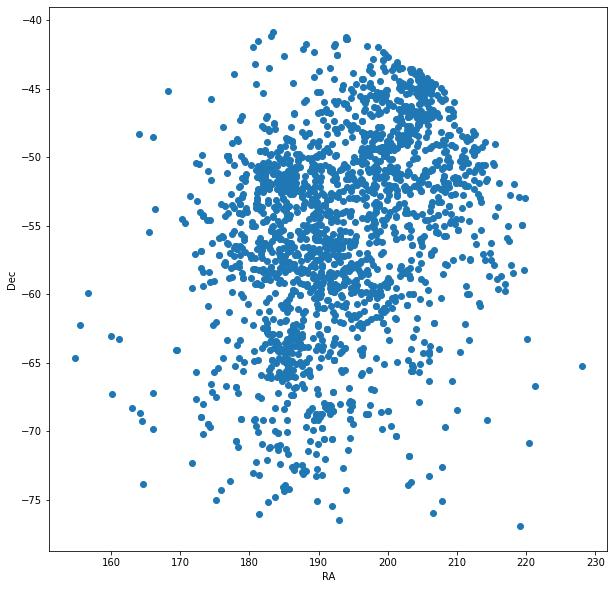

In [54]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()
plt.scatter(votable['RA_d'],votable['DEC_d'])
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

Las coordenadas mundiales (World Coordinates) sirven para ubicar una medida en un espacio de parámetros multidimensional. Un Sistema de Coordenadas Mundiales (WCS en inglés) especifica las coordenadas físicas, o mundiales (WC en inglés), que se adjuntan a cada píxel o spaxel de una imagen o matriz de $N$ dimensiones. Se ha desarrollado un elaborado conjunto de normas y convenciones para el formato FITS (Flexible Image Transport System) (Wells et al. 1981). Un ejemplo típico de WCS es la especificación de la Ascensión Recta (AR) y la Declinación (Dec) en el cielo asociada a una determinada ubicación de píxel o vóxel en una imagen celeste bidimensional (Greisen y Calabretta 2002; Calabretta y Greisen 2002).

Hay dos formas principales de inicializar un objeto WCS: con un diccionario de Python (o un objeto tipo diccionario, como la cabecera de un archivo FITS) o con listas de Python. En este ejemplo, inicializaremos un objeto astropy.wcs.WCS con dos dimensiones, como sería necesario para representar una imagen.

Adaptado y traducido de https://learn.astropy.org/tutorials/celestial_coords1.html

In [55]:
from astropy.wcs import WCS
# world coordinate system https://learn.astropy.org/tutorials/celestial_coords1.html

In [56]:
wcs_input_dict = {
    'CTYPE1': 'RA', 
    'CUNIT1': 'deg', 
    'CTYPE2': 'DEC', 
    'CUNIT2': 'deg'
}
wcs_helix = WCS(wcs_input_dict)

In [57]:
wcs_helix

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA'  'DEC'  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 0  0

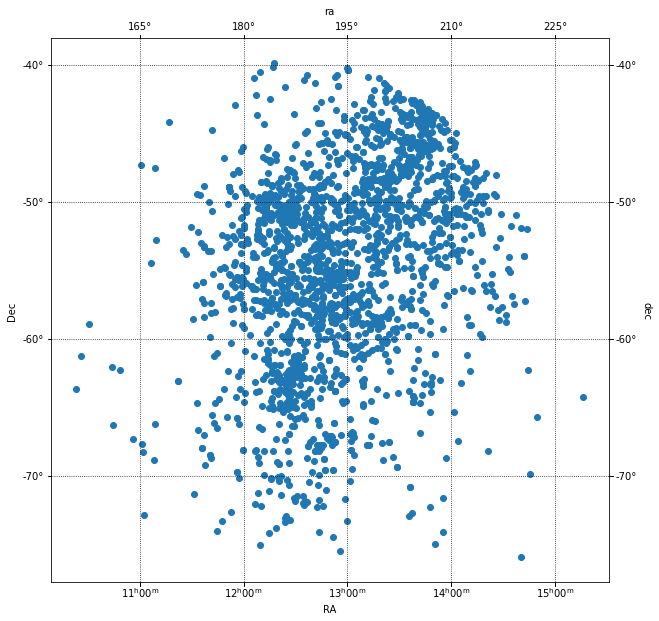

In [58]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_helix)
plt.scatter(votable['RA_d'],votable['DEC_d'])
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='black', ls='dotted')

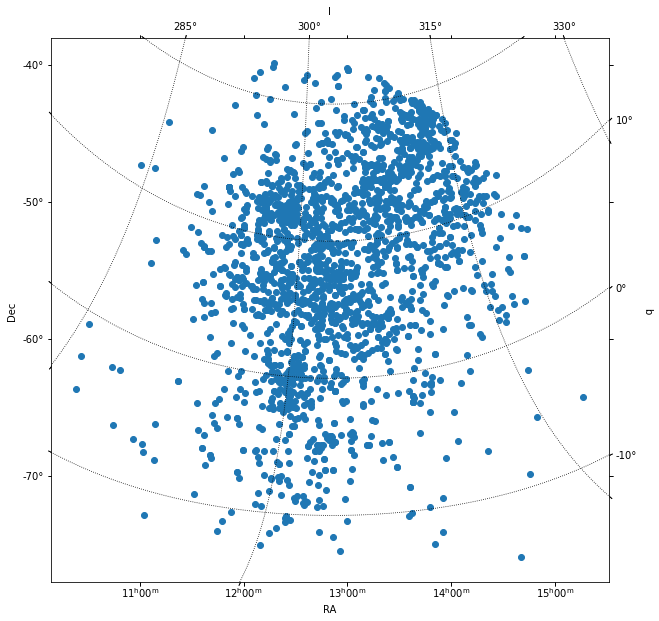

In [59]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_helix)
plt.scatter(votable['RA_d'],votable['DEC_d'])
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='black', ls='dotted')

Ejercicio: verificar que las coordenadas de alguna de las fuentes de LCC tiene coordenadas galácticas correctas.